# UMAP을 이용한 차원축소 및 HDBSCAN을 통한 군집화

# 1. UMAP을 이용한 차원축소

In [2]:
import numpy as np
import pandas as pd
import gzip
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [4]:
#데이터 읽어오기
import joblib

with open('../processed/forcluster_final.pickle', 'rb') as f:
    df = joblib.load(f)

In [5]:
df.shape

(183239, 50)

In [ ]:
df.info()

In [10]:
df.shape
df.reset_index(drop = False, inplace = True)

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

In [12]:
log_clustering_d = df.iloc[:, 3:]
log_clustering_u = df.iloc[:, 0]

In [ ]:
log_clustering = pd.concat([log_clustering_u, log_clustering_d], axis = 1)
log_clustering.head()

In [ ]:
#결측치 확인
log_clustering.isnull().sum()

In [15]:
# kbest에서 선택되지 않은 'houseown_type', 'yearly_income', 'company_period', 'insert_minute' 제거
log_clustering = log_clustering.drop(columns = ['houseown_type', 'yearly_income', 'company_period', 'insert_minute'])
print('전처리 이후 데이터 형태: ', log_clustering.shape) #47 -> 45 컬럼 축소

전처리 이후 데이터 형태:  (183239, 45)


In [16]:
#user_id와 application_id를 index로 설정
log_clustering.set_index(['user_id', 'application_id'], inplace=True)

In [ ]:
log_clustering.head()

In [47]:
#2개의 컬럼을 index로 만들었기 때문에 feature 45개 -> 43개로 변경
len(log_clustering.columns)

43

In [68]:
# 처리 마친 데이터프레임 저장
log_clustering.to_csv('../preprocessed/5_1_forcluster_final2.csv')

## scaling

In [48]:
# UMAP실행 전 feature별 값의 범위가 너무 차이나서 스케일 해주기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
log_clustering_scaled=scaler.fit_transform(log_clustering)  # X만 본인이 가지고 있는 변수로 넣어주기 (X는 label 없이 only feature만!)

In [49]:
log_clustering_scaled[:2] #scaling 잘 됐는지 확인

array([[ 1.09287962e-01, -4.78383262e-01, -1.31018581e-01,
        -1.10272203e+00,  3.88939016e-01, -3.20995567e-01,
         8.80469470e-01,  5.89473527e-01, -3.86991541e-03,
        -2.16909749e+00,  2.45136198e-01,  4.14456941e-01,
         6.70800930e-01, -2.87035809e-01,  9.34062348e-01,
        -7.59291289e-01,  6.53971405e-02, -2.89629110e+00,
        -8.19176484e-01, -6.65828291e-01, -6.96164415e-01,
        -3.94058900e-02, -5.38366369e-01, -4.83639916e-02,
         0.00000000e+00, -5.82351576e-01, -5.26624628e-01,
        -3.42174081e-02, -4.72347780e-01, -4.24395808e-02,
        -6.18647945e-01, -1.01288338e+00, -1.02711600e+00,
        -1.04033307e+00, -1.05179958e+00, -1.03308864e+00,
        -1.03265789e+00, -1.03147280e+00, -5.90626562e-01,
        -4.51893900e-01,  3.50590352e-02, -4.59632329e-01,
         7.37476253e-03],
       [ 7.04568032e-01,  1.68235715e-01, -1.15509966e-01,
         6.53032954e-01, -8.67267734e-01, -6.46259986e-01,
        -3.85688220e-01, -9.88

## UMAP
toplogical 데이터 분석으로 manifold learning기술을 기반으로 한 차원 축소 알고리즘
t-SNE, PCA 보다 카테고리 간 분리가 명확하게 되어있으며 빠른 시간에 차원을 축소할 수 있음. 두 가지 주요한 파라미터를 사용:

credits: [https://m.blog.naver.com/myohyun/222421460444](https://m.blog.naver.com/myohyun/222421460444)

**1) n_neighbors:**<br>
초기 고차원 그래프 생성 시에 사용되는 nearest neighbor의 숫자로 가장 중요한 파라미터임
n_neighbors의 수가 작으면 : local stracture에 집중
n_neighbors의 수가 크면 : global stracture에 집중

**2) min_dist:**<br>
저차원 공간에서 포인트간의 최소 거리
umap이 얼마나 촘촘히 데이터를 묶을건지를 조절
min_dist값이 작으면: 포인트들이 촘촘하게 무리지어있게 됨
min_dist값이 크면: 포인트들이 상대적으로 느슨하게 퍼져있게 됨
n_neighbors가 커질수록 고차원 그래프에서 이웃한 데이터포인트간의 연결을 늘려 데이터의 전체적인 군집을 훨씬 더 정확하게 반영할 수 있음
min_dist값이 커지면 클러스터링을 약화시키고 global structure를 덜 강조함

**3)n_components:**<br> 
줄여서 결과값으로 나오는 차원. 꼭 2차원이 아니어도 됨

In [ ]:
#UMAP이 없다면 해당 라이브러리 설치 필수
#!pip install umap-learn

In [50]:
import umap.umap_ as umap

In [51]:
### default setting:
#n_neighbors: float (optional, default 15) 
#min_dist: float (optional, default 0.1)
#n_components: int (optional, default 2)

reducer = umap.UMAP(low_memory = False, n_neighbors=15) 

In [52]:
embedding = reducer.fit_transform(log_clustering_scaled)
embedding.shape

(183239, 2)

In [53]:
print(f'원본데이터 수: {log_clustering_scaled.shape}')
print(f'차원축소한 데이터 수: {embedding.shape}')

원본데이터 수: (183239, 43)
차원축소한 데이터 수: (183239, 2)


In [54]:
#데이터프레임 형태로 변환
embedding_df = pd.DataFrame(embedding)
embedding_df.shape

(183239, 2)

In [55]:
embedding_df.head()

,0,1
0,-5.098753,10.198372
1,-9.797464,-0.173480
2,6.258368,14.753431
3,7.041417,-5.840258
4,-2.677657,9.164755


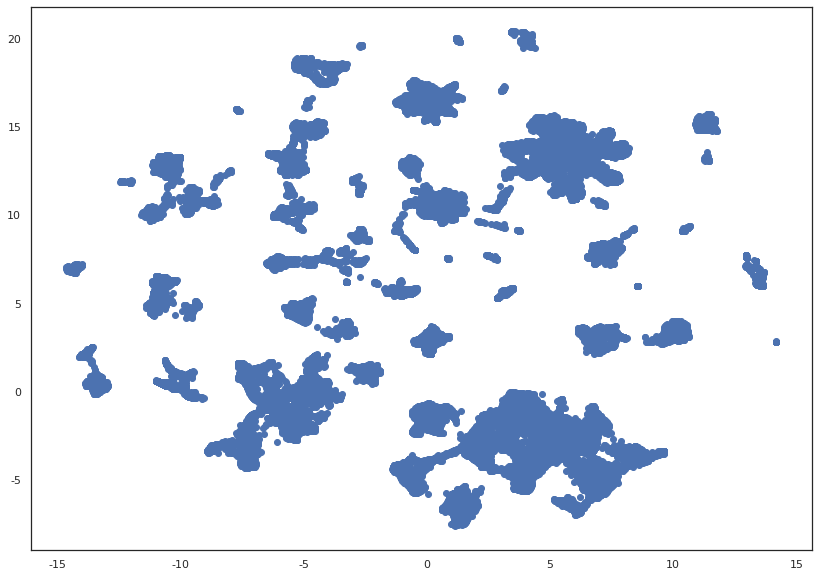

In [96]:
#UMAP 수행한 결과 확인
plt.scatter(embedding.T[0], embedding.T[1], color='b')
plt.savefig('../output/5_1_umap_result.png')
#plt.show()

In [70]:
#csv파일로 저장
embedding_df.to_csv('../preprocessed/5_2_umap_result.csv', index = False)

# 2. hdbscan을 통한 클러스터링 수행
dbscan + 계층적 클러스터링을 합한 개념
주요 하이퍼파라미터

credit: [https://hdbscan.readthedocs.io/en/latest/parameter_selection.html](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

**1)min_cluster_size**:<br>
하나의 군집에 최소로 들어갈 data 수

**2)min_samples**:<br> 
The larger the value of `min_samples`you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

**3)cluster_selection_epsilon**:<br> 
ensures that clusters below the given threshold are not split up any further. The choice of `cluster_selection_epsilon`depends on the given distances between your data points. For example, set the value to 0.5 if you don’t want to separate clusters that are less than 0.5 units apart.

In [ ]:
#HDBSCAN이 없다면 해당 라이브러리 설치 필수
#!pip install hdbscan

In [67]:
#UMAP으로 차원 축소한 데이터 불러오기
embedding = pd.read_csv('../preprocessed/5_2_umap_result.csv', index_col = 0)
embedding.head()

,0,1
0,-5.098753,10.198372
1,-9.797464,-0.173480
2,6.258368,14.753431
3,7.041417,-5.840258
4,-2.677657,9.164755


### HDBSCAN의 default value
default values:<br>
HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
    
#### <b>여러실험 결과 최적의 파라미터값을 찾아내어 군집화 수행</b> ####

In [60]:
import hdbscan
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5000, min_samples=500, cluster_selection_epsilon = 1.6, approx_min_span_tree=False)
hdbscan_model.fit(embedding)

HDBSCAN(approx_min_span_tree=False, cluster_selection_epsilon=1.6,
        min_cluster_size=5000, min_samples=500)

In [75]:
hdbscan_labels = list(hdbscan_model.labels_)
hdbscan_labels[:20]

[5, -1, 5, 1, 5, 1, 5, 1, 5, 1, 0, 0, -1, 5, -1, -1, 5, -1, 5, 1]

In [76]:
len(hdbscan_model.labels_)

183239

In [77]:
#군집 넘버의 max값(실제로는 -1군집, 0군집을 포함하여 총 7개)
hdbscan_model.labels_.max()

5

In [121]:
# 훈련 결과를 plotly를 사용하여 시각화
# jupyter lab에서 결과가 보이지 않아 숨겨놓음! vscode에서는 잘 보이는거 확인!
# 라이브러리 설치하고 돌려보면 interactive하게 시각화 가능
#!pip install plotly
#import plotly.express as px

#embedding_df['hdbscan_label'] = hdbscan_model.labels_
#hdb_data['hdbscan_label'] = hdb_data['hdbscan_label'].astype(str)

#fig = px.scatter(hdb_data, x='0', y='1', color='hdbscan_label')
#fig.update_layout(width=600, height=500)
#fig.show()

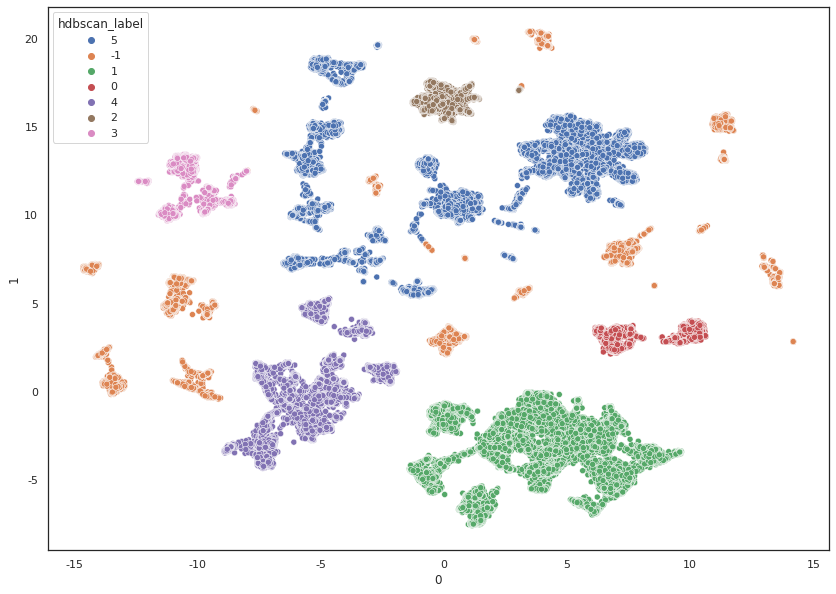

In [86]:
#seaborn의 scatterplot을 통한 시각화
import seaborn as sns
embedding['hdbscan_label'] = hdbscan_model.labels_
embedding['hdbscan_label'] = embedding['hdbscan_label'].astype(str)

ax = sns.scatterplot(x = '0', y = '1', hue = 'hdbscan_label', data = embedding)
plt.savefig('../output/5_2_hdbscan_scatter.png')
#plt.show()

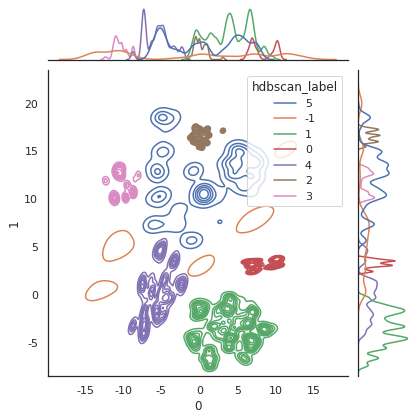

In [65]:
#seaborn의 jointplot을 통한 시각화
ax2 = sns.jointplot(x='0', y='1', hue = 'hdbscan_label', kind="kde", data = embedding)
plt.savefig('../output/5_3_hdbscan_jointplot.png')

In [79]:
#결과를 데이터프레임형태로 바꿔주기
log_clustering2 = pd.read_csv('../preprocessed/5_1_forcluster_final2.csv')

user_id = log_clustering2['user_id']
app_id = log_clustering2['application_id']
embedding_new = pd.concat([user_id, app_id, embedding], axis=1, ignore_index = True) 

In [ ]:
embedding_new.rename(columns = {0: 'user_id', 1:'application_id', 2:'first_feature', 3: 'second_feature', 4: 'label'}, inplace = True)
embedding_new.head()

In [ ]:
#각 군집 별 개수 확인(모든 군집이 1800개를 넘는 것을 볼 수 있음)
embedding_new.groupby(embedding_new['label'])['application_id'].count()

In [83]:
#csv파일로 저장
embedding_new.to_csv('../preprocessed/5_3_hdbscan_result.csv', index = False)

In [ ]:
#잘 저장되었는지 불러와 확인
dd = pd.read_csv('../preprocessed/5_3_hdbscan_result.csv')
dd.head()